In [23]:
import mne
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import scipy
import pywt

mne.set_log_level('WARNING')
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')

# Types
from typing import Annotated, Literal, TypeVar

DType = TypeVar("DType", bound=np.generic)
ArrayN = Annotated[npt.NDArray[DType], Literal['N']]

# Get Data

#### Bonn University

Sets A and B are from healthy patients, while Sets C, D, and E are from epileptic patients.

Sets C and D are seizure-free segments while set E is during a seizure.

Each set contains 100 single-channel EEG segments of 23.6-sec duration.

In [24]:
def get_data_bonn(sets_to_read: list, time_segments: int, time_points: int) -> dict[str, np.ndarray]:
    """
    Returns data for all specified sets from the Bonn University dataset
    Data returned is in a dictionary with set letters as keys and 3d numpy arrays (time_segments, channels, time_points) as values
    """
    data = dict()

    # maps from set_letter to set_letter_alternate (for the filenames)
    sets_to_file_prefixes = {
        'A': 'Z',
        'B': 'O',
        'C': 'N',
        'D': 'F',
        'E': 'S'
    }

    for set in sets_to_read:
        if set not in sets_to_file_prefixes:
            continue

        set_letter_alternate = sets_to_file_prefixes[set]

        set_data = np.zeros((time_segments, channels, time_points))
        for i in range(time_segments):
            filename = f'data/bonn/SET {set}/{set_letter_alternate}{str(i+1).zfill(3)}.txt'
            z = np.loadtxt(filename)
            set_data[i][0] = z[:time_points]

        data[set] = set_data

    return data

time_segments, channels, time_points = 100, 1, 4096
freq = 173.61

sets_to_use = ['A', 'E']
data_all_sets = get_data_bonn(sets_to_use, time_segments=time_segments, time_points=time_points)
print(data_all_sets['A'].shape)

(100, 1, 4096)


#### Create mne.Raw objects

In [25]:
raws_all_sets = {}
for set in sets_to_use:

    raw_one_set = []
    for time_segment in data_all_sets[set]:
        info = mne.create_info(
            ch_names=[f'c{i}' for i in range(channels)],
            sfreq=freq,
            ch_types='eeg',
        )
        raw_one_set.append(mne.io.RawArray(time_segment, info))

    raws_all_sets[set] = raw_one_set

# Preprocessing

#### Filtering

In [26]:
for set in raws_all_sets:
    for i, time_segment in enumerate(raws_all_sets[set]):
        # raws_all_sets[set][i].copy().compute_psd().plot()

        # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500)

        raws_all_sets[set][i] = raws_all_sets[set][i].notch_filter(freqs=50)
        raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=0.1, h_freq=50)

        data_all_sets[set][i] = raws_all_sets[set][i]._data

        # raws_all_sets[set][i].copy().compute_psd().plot();
        # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500);
print(data_all_sets['A'].shape)

/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=0.1, h_freq=50)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=0.1, h_freq=50)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=0.1, h_freq=50)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning:

(100, 1, 4096)


/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=0.1, h_freq=50)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=0.1, h_freq=50)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=0.1, h_freq=50)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_32217/2497669358.py:8: RuntimeWarning:

#### Segmentation into intervals

# Feature Extraction

#### Define 1D multilevel DWT function for each time segment (using Daubechies 4)

In [27]:
def discrete_wavelet_transform(data):
    # 1D multilevel DWT
    cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(data, wavelet='db4', level=4)
    # low frequencies => high time resolution, low freq resolution
    # high frequences => low time resolution, high freq resolution
    # print(cA4.shape)  # 0.1-4 Hz   60
    # print(cD4.shape)  # 4-8 Hz     60
    # print(cD3.shape)  # 8-15 Hz    114
    # print(cD2.shape)  # 15-30 Hz   222
    # print(cD1.shape)  # 30-60 Hz   437
    return cA4, cD4, cD3, cD2, cD1

#### Define feature vector functions

In [28]:
def variance(data) -> ArrayN[np.float64]:
    variance_data = np.var(data, axis=1)
    return variance_data  # shape (# channels,)

def standard_deviation(data) -> ArrayN[np.float64]:
    std_data = np.std(data, axis=1)
    return std_data

def kurtosis(data) -> ArrayN[np.float64]:
    # fisher = True is default, which subtracts 3 from the final value
    return scipy.stats.kurtosis(data, axis=1, fisher=False)

def nn_shannon_entropy(data) -> ArrayN[np.float64]:
    # shannon entropy - a measure of how uncertain the data is (or how surprising it is?)
    # squared so log is never taken of a negative number in the data
    squared = data**2
    output = np.sum(squared * np.log(squared), axis=1)
    return output
    
    # output2 = np.sum(data * np.log(data), axis=1)
    # return output2   # returns nan because there are negative numbers
    return scipy.stats.entropy(data, axis=1)  # returns -inf

def logarithmic_band_power(data) -> ArrayN[np.float64]:
    n = data.shape[1]
    return np.log(np.sum(data**2, axis=1) / n)


def compute_features(data):  #-> shape (100, 5)
    return np.array([
        logarithmic_band_power(data),
        standard_deviation(data),
        variance(data),
        kurtosis(data),
        nn_shannon_entropy(data)
    ], dtype=np.float64).T

#### Define feature vector graphing functions

In [29]:
BandType = Literal['A4', 'D4', 'D3', 'D2', 'D1']
FeatureType = Literal['LBP', 'Std', 'Var', 'Kur', 'SE']

# GETS FEATURE FROM 25 LENGTH FEATURE VECTORS
def get_feature(
        feature_vector: np.ndarray,
        band: BandType,
        feature: FeatureType
    ) -> np.float64:
    
    bands = ['A4', 'D4', 'D3', 'D2', 'D1']
    features = ['LBP', 'Std', 'Var', 'Kur', 'SE']
    
    row = bands.index(band)
    col = features.index(feature)

    return feature_vector[
        # channel * len(bands) * len(features)
        row * len(features)
        + col
    ]

def graph_feature_vectors(feature_vectors_all_sets: dict[str, np.ndarray], band_x: BandType, band_y: BandType, feature: FeatureType, graph_individual_channels: bool = False):
    colors = ['blue', 'green', 'yellow', 'red', 'black']
    # colors = ['blue', 'blue', 'blue', 'green', 'green']

    # Loop through each available set
    for i, set in enumerate(feature_vectors_all_sets):
        feature_vectors = feature_vectors_all_sets[set]  # shape (# tsegments, # channels, 25)

        # Loop through each time segment
        for feature_vector in feature_vectors:  # shape (# channels, 25)
            if graph_individual_channels:
            # Loop thru channels and only graph specific parts of each feature vector
                for channel in range(channels):
                    x = get_feature(feature_vector[channel], band=band_x, feature=feature)
                    y = get_feature(feature_vector[channel], band=band_y, feature=feature)

                    plt.scatter(x, y, color=colors[i], s=4)
            else:
                x = get_feature(feature_vector[0], band=band_x, feature=feature)
                y = get_feature(feature_vector[0], band=band_y, feature=feature)

                plt.scatter(x, y, color=colors[i], s=4)
    
    plt.show()

#### Compute feature vector for each segment

(100, 1, 25)
(100, 1, 25)


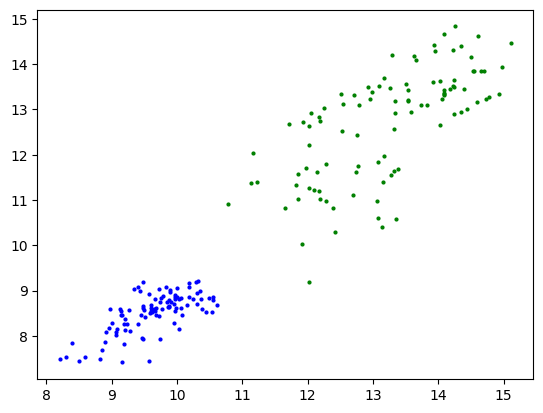

In [30]:
feature_vectors_all_sets: dict[str, np.ndarray] = {}   # set → ndarray shape (# tsegments, # channels, 25)

for set in data_all_sets:
    tsegments = data_all_sets[set]   # shape (# tsegments, # channels, 4096)

    segment_feature_vectors = []
    for segment_data in tsegments:  # shape (# channels, 4096)
        # Perform discrete wavelet transform on data
        dwt_outputs = discrete_wavelet_transform(data=segment_data)   # shape (# channels, <4096)
        # print([x.shape for x in dwt_outputs])  # [(1, 262), (1, 262), (1, 518), (1, 1029), (1, 2051)]

        # 5 features are extracted (LBP, SD, var, kur, SE) from each DWT-extracted freq band
        outputs = np.hstack([compute_features(dwt_output) for dwt_output in dwt_outputs])  # (# channels, 25)
        segment_feature_vectors.append(outputs)  # shape (# channels, 25)

    feature_vectors_all_sets[set] = np.array(segment_feature_vectors)
    print(feature_vectors_all_sets[set].shape)

graph_feature_vectors(feature_vectors_all_sets, band_x='A4', band_y='D4', feature='LBP', graph_individual_channels=True)   # A4 = delta = 0.1-4 Hz, D4 = theta = 4-8 Hz

# Classification

#### Attach labels

#### K-nearest neighbors